

```
# This is formatted as code
```



In [ ]:
import functools

import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns



np.set_printoptions(precision=3, suppress=True)

TRAIN_DATA_PATH = '/content/train.csv'
TEST_DATA_PATH = '/content/test.csv'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dowbload kaggle data locally



In [ ]:
!pip install kaggle

os.environ['KAGGLE_USERNAME'] = "mbellezi"
os.environ['KAGGLE_KEY'] = "66e4b62af695e9ae4fc3a9001f584357"
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 66.3MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 33.0MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.5MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.3MB/s]


Define target column and feature columns

Load the data from CSV fo Pandas Dataframe

In [ ]:
raw_data = pd.read_csv(TRAIN_DATA_PATH)
raw_test_data = pd.read_csv(TEST_DATA_PATH)

Define colums

In [ ]:
TARGET_COLUMN = 'SalePrice'

NUMERIC_FEATURES = []
CATEGORICAL_FEATURES = []

for column in raw_data.columns:
  if raw_data[column].dtypes==int or raw_data[column].dtypes==float:
    NUMERIC_FEATURES.append(column)
  else:
    CATEGORICAL_FEATURES.append(column)

NUMERIC_FEATURES.remove('Id')
NUMERIC_FEATURES.remove(TARGET_COLUMN)

Remove features with NAN values

In [ ]:
numericWithNan = {}
categoricalWithNan = {}
CUT_PERCENT = 6.0

for column in NUMERIC_FEATURES:
  nulls = raw_data[column].isnull().sum()
  if (nulls > 0):
    numericWithNan[column] = 100*nulls/raw_data[column].shape[0]

keys = list(numericWithNan)
for key in keys:
  percent = numericWithNan[key]
  if (percent > CUT_PERCENT):
    print('Removing Numerical Colunm '+key+': '+'{:02.2f}%'.format(percent))
    NUMERIC_FEATURES.remove(key)
    del numericWithNan[key]

for column in CATEGORICAL_FEATURES:
  nulls = raw_data[column].isnull().sum()
  if (nulls > 0):
    categoricalWithNan[column] = 100*nulls/raw_data[column].shape[0]

keys = list(categoricalWithNan)
for key in keys:
  percent = categoricalWithNan[key]
  if (percent > CUT_PERCENT):
    print('Removing Categorical Colunm '+key+': '+'{:02.2f}%'.format(percent))
    CATEGORICAL_FEATURES.remove(key)
    del categoricalWithNan[key]



Removing Numerical Colunm LotFrontage: 17.74%
Removing Categorical Colunm Alley: 93.77%
Removing Categorical Colunm FireplaceQu: 47.26%
Removing Categorical Colunm PoolQC: 99.52%
Removing Categorical Colunm Fence: 80.75%
Removing Categorical Colunm MiscFeature: 96.30%


Replacing missimg Categorical data with None and interploate missing numerical data

In [ ]:
for key in numericWithNan:
  raw_data[key] = raw_data[key].interpolate()

for key in categoricalWithNan:
  raw_data[key] = raw_data[key].fillna('none')

Show features

In [ ]:
print( len(NUMERIC_FEATURES), 'numeric columns: ', NUMERIC_FEATURES)
print( len(CATEGORICAL_FEATURES), 'categorical columns: ', CATEGORICAL_FEATURES)
print( 'ID and SalePrice are seperated')

35 numeric columns:  ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
38 categorical columns:  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'Ga

Separete train and dev sets

In [ ]:

# raw_train_data[['OverallCond', TARGET_COLUMN]].plot.scatter(x='OverallCond', y=TARGET_COLUMN);

# logOver = raw_train_data['OverallCond', TARGET_COLUMN]

# logOver.plot(kind='hist')


# for feature in NUMERIC_FEATURES:
  # raw_data[feature] = np.log1p(raw_data[feature])

dev_size = 200
raw_data = raw_data.sample(frac=1)
raw_train_data = raw_data.head(raw_data.shape[0] - dev_size)
raw_dev_data = raw_data.tail(dev_size)

print('Train set size: ', raw_train_data.shape[0])
print('Dev set size: ', raw_dev_data.shape[0])

Train set size:  1260
Dev set size:  200


Normalize the numerical data and cast types


In [ ]:
# DESC = np.log1p(raw_train_data[NUMERIC_FEATURES]).describe()

DESC = raw_train_data[NUMERIC_FEATURES].describe()


price_mean = np.log1p(raw_train_data[TARGET_COLUMN]).mean()
price_sdt = np.log1p(raw_train_data[TARGET_COLUMN]).std()

def clean_and_normalize(dataframe, num_features, cat_features, target):

  for feature in num_features:
      dataframe[feature] = np.nan_to_num(dataframe[feature])

  res = dataframe[num_features + cat_features + [target]].copy()

  for feature in num_features:
      # res[feature] = np.log1p(res[feature])
      res[feature] = tf.cast((res[feature] - DESC[feature]['mean']) / DESC[feature]['std'], tf.float32)

  for feature in cat_features:
      res[feature] = res[feature].astype(str)

  res[target] = np.log1p(res[target])

  res[target] = tf.cast((res[target] - price_mean) / price_sdt , tf.float32)

  return res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(array([  1.,   2.,   1.,   0.,   0.,   0.,   1.,   3.,   4.,   3.,   4.,
          1.,   3.,  17.,  20.,  20.,  15.,  26.,  49.,  50.,  58.,  86.,
        105.,  78.,  78.,  70.,  90.,  75.,  54.,  49.,  49.,  49.,  44.,
         38.,  19.,  24.,  19.,  12.,  11.,  12.,   6.,   4.,   3.,   1.,
          1.,   2.,   1.,   0.,   0.,   2.]),
 array([-3.934, -3.78 , -3.625, -3.471, -3.316, -3.162, -3.007, -2.853,
        -2.699, -2.544, -2.39 , -2.235, -2.081, -1.926, -1.772, -1.617,
        -1.463, -1.308, -1.154, -0.999, -0.845, -0.69 , -0.536, -0.382,
        -0.227, -0.073,  0.082,  0.236,  0.391,  0.545,  0.7  ,  0.854,
         1.009,  1.163,  1.318,  1.472,  1.627,  1.781,  1.935,  2.09 ,
         2.244,  2.399,  2.553,  2.708,  2.862,  3.017,  3.171,  3.326,
         3.48 ,  3.635,  3.789], dtype=float32),
 <a list of 50 Patch objects>)

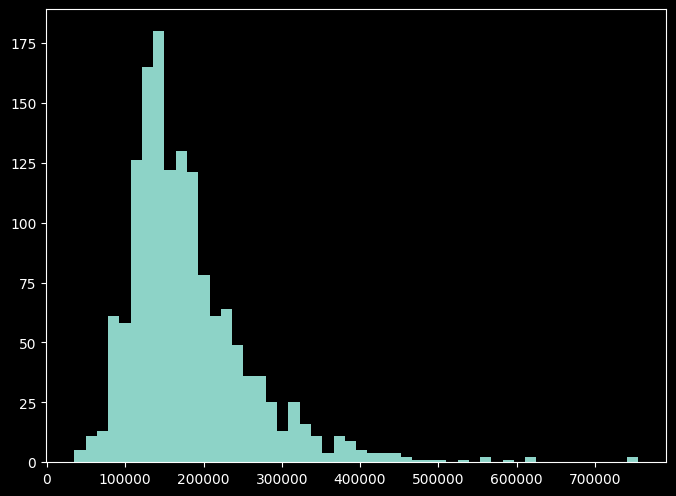

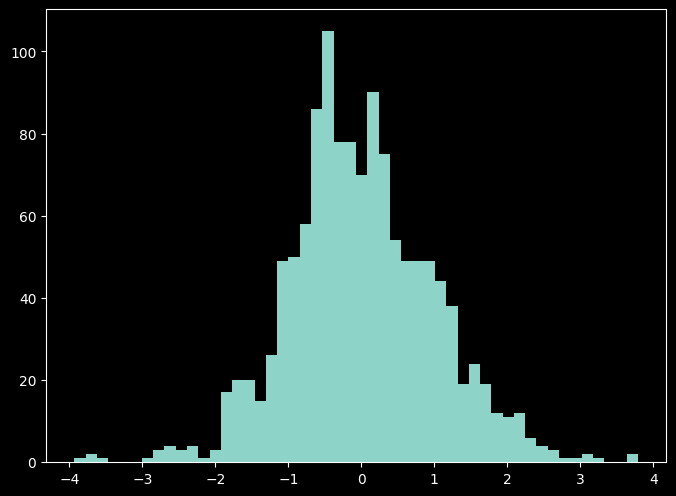

In [ ]:
train = clean_and_normalize(raw_train_data, NUMERIC_FEATURES, CATEGORICAL_FEATURES, TARGET_COLUMN)
dev = clean_and_normalize(raw_dev_data, NUMERIC_FEATURES, CATEGORICAL_FEATURES, TARGET_COLUMN)

plt.figure(num=2, figsize=(8, 6), dpi=100)
plt.hist(raw_data[TARGET_COLUMN], bins = 50)
plt.figure(num=1, figsize=(8, 6), dpi=100)
plt.hist(train[TARGET_COLUMN], bins = 50)


# print(train[NUMERIC_FEATURES])
# print(train[CATEGORICAL_FEATURES])
# print(train[TARGET_COLUMN])


Create the final train data casting types and concatenate numerical and cathegorical data

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size=64

train_dataset = df_to_dataset(train, TARGET_COLUMN, shuffle=True, batch_size=batch_size)
dev_dataset = df_to_dataset(dev, TARGET_COLUMN, shuffle=False, batch_size=batch_size)


In [ ]:
for feature_batch, label_batch in train_dataset.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of LandContour:', feature_batch['LandContour'])
  print('A batch of targets:', label_batch )

Every feature: ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleTy

In [ ]:
example_batch = next(iter(train_dataset))[0]

# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

# LandContour = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('LandContour',train['LandContour'].unique()))
# demo(LandContour)

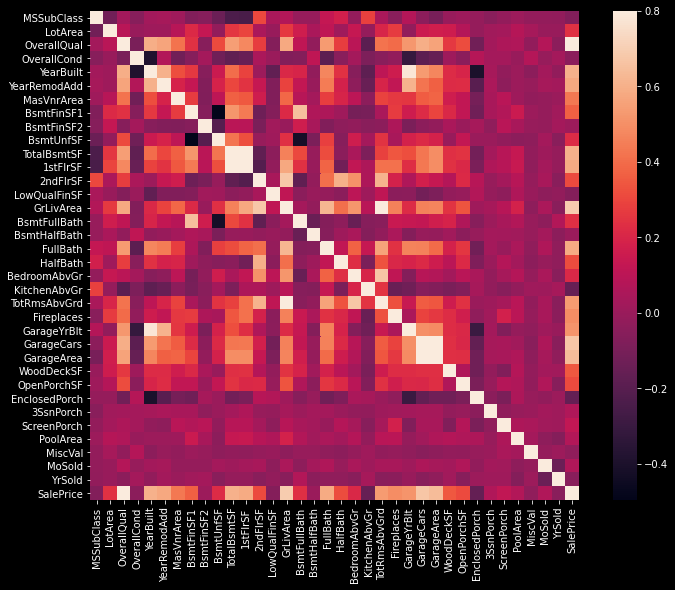

In [ ]:
plt.style.use("dark_background")
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
ax.xaxis.label.set_color('white')
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
def plot_history(history):
  plt.figure(num=None, figsize=(8, 6), dpi=100)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.ylim((0, 0.2))
  plt.show()

In [ ]:
tf.compat.v1.reset_default_graph()
tf.random.set_seed(100)
feature_columns = []

for col in NUMERIC_FEATURES:
  col = tf.feature_column.numeric_column(col)
  feature_columns.append(col)

for col in CATEGORICAL_FEATURES:
  col = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(col,train[col].unique()))
  feature_columns.append(col)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
def exp_decay(epoch):
  initial_lrate = 0.01
  k = 0.01
  lrate = initial_lrate * exp(-k*t)
  return lrate

r_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.005,
            decay_steps=(1000), 
            decay_rate=0.1
        )

def build_model2():  
  model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(512, 
                          kernel_initializer=tf.keras.initializers.glorot_normal, 
                          # kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                          activation='relu'),
    tf.keras.layers.Dense(512, 
                          kernel_initializer=tf.keras.initializers.glorot_normal, 
                          # kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                          activation='relu'),
    tf.keras.layers.Dense(512, 
                          kernel_initializer=tf.keras.initializers.glorot_normal, 
                          # kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                          activation='relu'),
    tf.keras.layers.Dense(1),
  ])

  # lrate = tf.keras.optimizers.schedules.LearningRateSchedule(exp_decay)

  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.RMSprop(r_schedule),
                # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse'])
  return model

model2 = build_model2()

In [ ]:
history2 = model2.fit(train_dataset, validation_data=dev_dataset, epochs=200)

Epoch 1/200
20/20 [==============================] - 2s 81ms/step - loss: 176.9474 - mae: 4.6286 - mse: 176.9474 - val_loss: 0.3312 - val_mae: 0.3869 - val_mse: 0.3312
Epoch 2/200
20/20 [==============================] - 0s 18ms/step - loss: 0.2785 - mae: 0.3112 - mse: 0.2785 - val_loss: 0.1765 - val_mae: 0.3270 - val_mse: 0.1765
Epoch 3/200
20/20 [==============================] - 0s 19ms/step - loss: 0.1746 - mae: 0.3106 - mse: 0.1746 - val_loss: 0.3083 - val_mae: 0.4568 - val_mse: 0.3083
Epoch 4/200
20/20 [==============================] - 0s 19ms/step - loss: 0.1588 - mae: 0.2972 - mse: 0.1588 - val_loss: 0.1023 - val_mae: 0.2451 - val_mse: 0.1023
Epoch 5/200
20/20 [==============================] - 0s 19ms/step - loss: 0.2231 - mae: 0.2964 - mse: 0.2231 - val_loss: 0.1575 - val_mae: 0.2789 - val_mse: 0.1575
Epoch 6/200
20/20 [==============================] - 0s 18ms/step - loss: 0.1307 - mae: 0.2676 - mse: 0.1307 - val_loss: 0.1331 - val_mae: 0.2666 - val_mse: 0.1331
Epoch 7/200


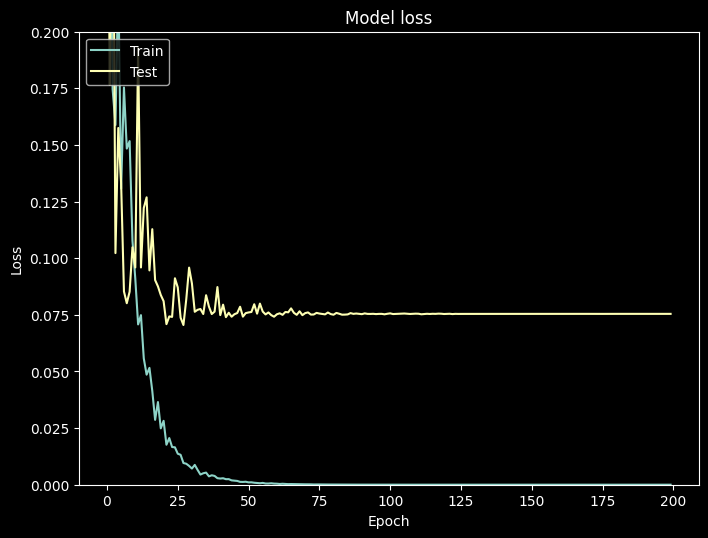

In [ ]:
# plot_history(history1)
plot_history(history2)


In [ ]:
def calculate_price(price):
  return np.expm1((price * price_sdt)+price_mean)


In [ ]:
model2.summary()
model2.evaluate(dev_dataset)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense_50 (Dense)             multiple                  141312    
_________________________________________________________________
dense_51 (Dense)             multiple                  262656    
_________________________________________________________________
dense_52 (Dense)             multiple                  262656    
_________________________________________________________________
dense_53 (Dense)             multiple                  513       
Total params: 667,137
Trainable params: 667,137
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 5ms/step - loss: 0.0754 - mae: 0.1926 - mse: 0.0754


[0.07543359696865082, 0.19261109828948975, 0.07543359696865082]

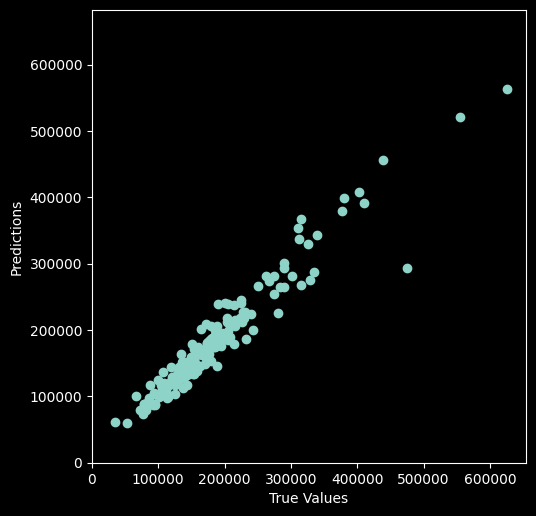

In [ ]:
test_predictions = model2.predict(dev_dataset).flatten()

plt.figure(num=None, figsize=(8, 6), dpi=100)
plt.scatter(calculate_price(dev[TARGET_COLUMN]), calculate_price(test_predictions))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])

_ = plt.plot()

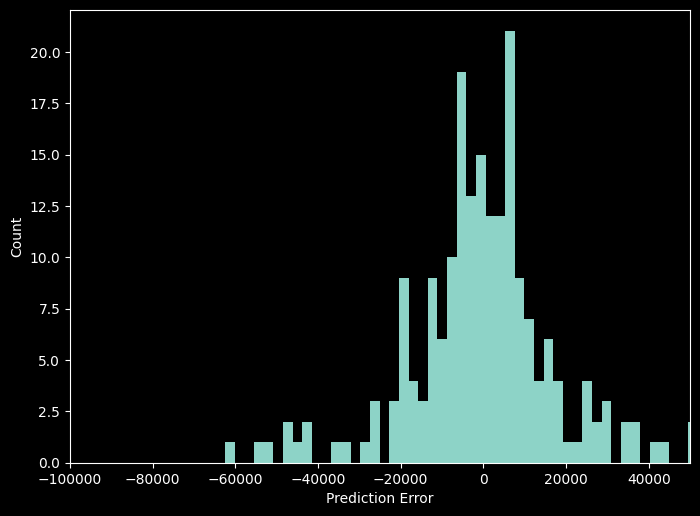

In [ ]:
error = calculate_price(test_predictions) - calculate_price(dev[TARGET_COLUMN]) 
plt.figure(num=None, figsize=(8, 6), dpi=100)
plt.hist(error, bins = 100)
plt.xlim((-100000, 50000))
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

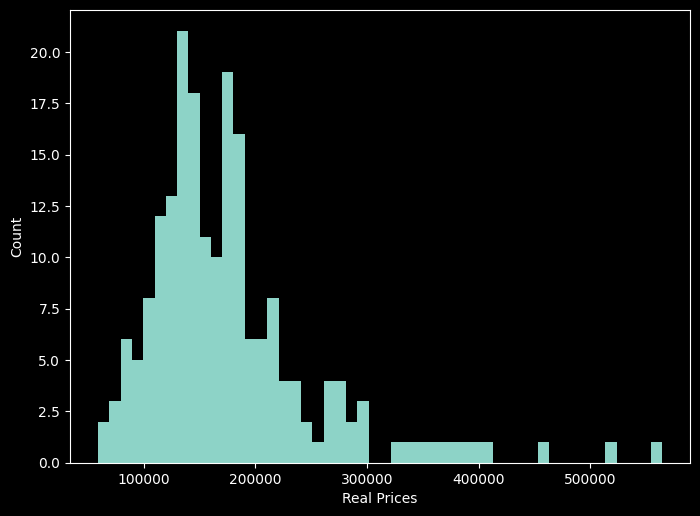

In [ ]:
realprices = calculate_price(test_predictions)
plt.figure(num=None, figsize=(8, 6), dpi=100)
plt.hist(realprices, bins = 50)
plt.xlabel("Real Prices")
_ = plt.ylabel("Count")

In [ ]:

p = [ 100000, 200000, 300000 ]
p = np.log1p(p)
print(p)
mean = p.mean()
std = p.std()
p = (p/mean) - std


[11.513 12.206 12.612]


In [ ]:
print(p)


[0.497 0.554 0.588]


In [ ]:
p = ((p+std)*mean)
print(p)
p = np.expm1(p)
print(p)

[11.513 12.206 12.612]
[100000. 200000. 300000.]
